
Finetuning and Feature Extraction of Torchvision Models
=============================

I conbined the two tutorials docs to get this document

In this document we will perform two types of transfer learning:
finetuning and feature extraction. In **finetuning**, we start with a
pretrained model and update *all* of the model’s parameters for our new
task, in essence retraining the whole model. In **feature extraction**,
we start with a pretrained model and only update the final layer weights
from which we derive predictions. It is called feature extraction
because we use the pretrained CNN as a fixed feature-extractor, and only
change the output layer.


In general both transfer learning methods follow the same few steps:

-  Initialize the pretrained model
-  Reshape the final layer(s) to have the same number of outputs as the
   number of classes in the new dataset
-  Define for the optimization algorithm which parameters we want to
   update during training
-  Run the training step

In [1]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy 
from torch.utils.tensorboard import SummaryWriter


print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
%matplotlib inline
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter("..tensorboard/fake_env")

PyTorch Version:  1.13.1
Torchvision Version:  0.14.1


Inputs
------

- set the ``data_dir`` input to the root directory of the dataset. 

- ``model_name`` input is the name of the model you wish to use and must be selected from this list:

   [resnet, alexnet, vgg, squeezenet, densenet, inception]
- ``num_classes`` is the number of classes in the dataset,
- ``batch_size`` is the batch size used for training and may be adjusted according to the capability of your
machine, 
- ``num_epochs`` is the number of training epochs we want to run,
- ``feature_extract`` is a boolean that defines if we are finetuning or feature extracting.  If ``feature_extract = False``, the model is finetuned and all model parameters are updated. If ``feature_extract = True``, only the last layer parameters are updated, the others remain fixed.




In [3]:

# Top level data directory. Here we assume the format of the directory conforms 

#   to the ImageFolder structure
data_dir = '../data/fake'# 

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
# resnet uses resnet 18
model_name = "resnet"

# need to set this one to automatically to set the parameter for the model
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for 
num_epochs = 25

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

Helper Functions
----------------

Before we write the code for adjusting the models, lets define a few
helper functions.

Model Training and Validation Code


In [4]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            if phase =='train':
                writer.add_scalar('epoch_loss/Train', epoch_loss, epoch)
                writer.add_scalar('epoch_acc/Train', epoch_acc, epoch)
            else:
                writer.add_scalar('epoch_loss/Val', epoch_loss, epoch)
                writer.add_scalar('epoch_acc/Val', epoch_acc, epoch)
            
            #rint('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

Set Model Parameters’ .requires_grad attribute
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

This helper function sets the ``.requires_grad`` attribute of the
parameters in the model to False when we are feature extracting. By
default, when we load a pretrained model all of the parameters have
``.requires_grad=True``, which is fine if we are training from scratch
or finetuning. However, if we are feature extracting and only want to
compute gradients for the newly initialized layer then we want all of
the other parameters to not require gradients. This will make more sense
later.




In [5]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

Initialize and Reshape the Networks
-----------------------------------

Finally, notice that inception_v3 requires the input size to be (299,299), whereas all of the other models expect (224,224).

Notice, many of the models have similar output structures, but each must be handled slightly differently. Also, check out the printed model architecture of the reshaped network and make sure the number of output features is the same as the number of classes in the dataset.

In [6]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18, I revised it to resnet 34
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
# print(model_ft)

/top/students/GRAD/ME/jacksee/home/.conda/envs/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/top/students/GRAD/ME/jacksee/home/.conda/envs/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Load Data
---------

Now that we know what the input size must be, we can initialize the data transforms, image datasets, and the dataloaders. We use 
- `ImageFolder` is a class provided by the PyTorch library that allows you to easily load and preprocess a set of images stored in a folder structure.
- Loading data needs to be after the initialize model code, to obtain the correct input dimension. 

In [7]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size, scale=(0.1, 1.3)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")
print(data_dir)
da = datasets.ImageFolder(os.path.join(data_dir, 'val'))
print(da.class_to_idx)

Initializing Datasets and Dataloaders...
../data/fake
{'fake_grass': 0, 'white_paper': 1}


In [8]:
# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=10) for x in ['train', 'val']}

class_names = image_datasets['train'].classes # return the number of classes

#class_names = image_datasets['train'].classes # return the number of classes
# Number of classes in the dataset
#num_classes = len(class_names) # it will be passed to modify the last layer of the model



### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



In [9]:
# Get a batch of training data that is already associated with its lable. 
inputs, classes = next(iter(dataloaders_dict['train']))
type(inputs.numpy())
def img_unmean(inp):
    mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    inp = std * inp + mean
    inp = torch.clamp(inp, 0, 1)
    return inp


# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
out = img_unmean(out)
print(out.shape)
writer.add_image('objects', out)
writer.add_graph(model_ft, inputs)


torch.Size([3, 906, 1810])


Create the Optimizer
--------------------

Now that the model structure is correct, the final step for finetuning
and feature extracting is to create an optimizer that only updates the
desired parameters. Recall that after loading the pretrained model, but
before reshaping, if ``feature_extract=True`` we manually set all of the
parameter’s ``.requires_grad`` attributes to False. Then the
reinitialized layer’s parameters have ``.requires_grad=True`` by
default. So now we know that *all parameters that have
.requires_grad=True should be optimized.* Next, we make a list of such
parameters and input this list to the SGD algorithm constructor.

To verify this, check out the printed parameters to learn. When
finetuning, this list should be long and include all of the model
parameters. However, when feature extracting this list should be short
and only include the weights and biases of the reshaped layers.




In [10]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


Run Training and Validation Step
--------------------------------

Finally, the last step is to setup the loss for the model, then run the
training and validation function for the set number of epochs. Notice,
depending on the number of epochs this step may take a while on a CPU.
Also, the default learning rate is not optimal for all of the models, so
to achieve maximum accuracy it would be necessary to tune for each model
separately.




In [11]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))
writer.close()

Epoch 0/24
----------

Epoch 1/24
----------

Epoch 2/24
----------

Epoch 3/24
----------

Epoch 4/24
----------

Epoch 5/24
----------

Epoch 6/24
----------

Epoch 7/24
----------

Epoch 8/24
----------

Epoch 9/24
----------

Epoch 10/24
----------

Epoch 11/24
----------

Epoch 12/24
----------

Epoch 13/24
----------

Epoch 14/24
----------

Epoch 15/24
----------

Epoch 16/24
----------

Epoch 17/24
----------

Epoch 18/24
----------

Epoch 19/24
----------

Epoch 20/24
----------

Epoch 21/24
----------

Epoch 22/24
----------

Epoch 23/24
----------

Epoch 24/24
----------

Training complete in 14m 13s
Best val Acc: 1.000000


### Visualizing the model predictions

Generic function to display predictions for a few images




In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    # inp is the input
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders_dict['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

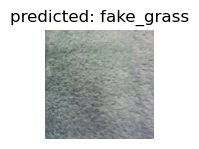

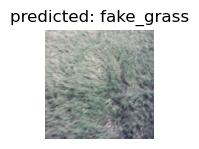

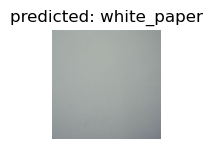

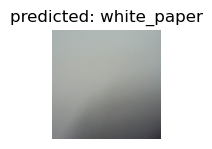

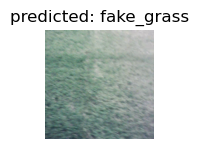

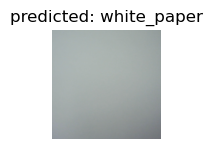

In [13]:
visualize_model(model_ft)

In [14]:
model_path = '../models/fake_env'
model_name = os.path.join(model_path, 'fake_env.pth')
os.makedirs(model_path, exist_ok=True)
torch.save(model_ft, model_name) # I added this to save the best_model

Save a model to onnx
-----

In [13]:
# Load the PyTorch model
# model = torch.load('models/terrains_indoor/terrain_indoor_rt18.pth')
model_= torch.nn.Sequential(model_ft, torch.nn.Softmax(1))
# Set the input to the appropriate size and type
input_size = torch.randn(1, 3, 224, 224).to(device) # move input tensor to GPU
model_ = model_.to(device)
# Create direc
model_path = '../models/fake_env'
model_name = os.path.join(model_path, 'fake_env.onnx')
os.makedirs(model_path, exist_ok=True)
# Export the PyTorch model to ONNX format
# export the model
input_names = [ "input_0" ]
output_names = [ "output_0" ]
print('Export successful')
torch.onnx.export(model_, input_size, model_name , verbose=True, input_names=input_names, output_names=output_names)

Export successful


Read a saved model
-----

In [ ]:
for name, layer in model_ft.named_modules():
    print(name, layer)

Abandoned
------


In [ ]:
   
# see what is out
imshow(out, title=[class_names[x] for x in classes])


Visuallize the history
-------------

In [ ]:
# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and

ohist = []
ohist = [h.cpu().numpy() for h in hist]
plt.title("Validation Accuracy vs. Number of Training Epochs")

plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.ylim((0.98,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()